In [1]:
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
import networkx as nx
import seaborn as sns
import sys

sys.path.append('..')

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx
from CD_methods import SCM_learner, observational_learner_Poisson, interventional_learner_Poisson

from tqdm import tqdm
from functions import *


In [2]:
example_network = torch.load('../data/c_elegans_data.pt')


In [3]:
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [4]:
n_obs = 10
n_neurons = example_network.num_nodes
n_hidden = n_neurons - n_obs

G = to_networkx(example_network, node_attrs = ['position'])
position_dict = nx.get_node_attributes(G, 'position')
sample_space = []

#first sample from head region
upper_pos_thr = 0.25
lower_pos_thr = 0.
for neuron in position_dict:
    if position_dict[neuron] > lower_pos_thr and position_dict[neuron] < upper_pos_thr:
        sample_space.append(neuron)

index_obs = np.sort(np.random.choice(sample_space, size = n_obs, replace = False))

G_obs = nx.subgraph(G, index_obs)

index_hidden = [node for node in range(n_neurons) if node not in index_obs]
confounders = []

for node in index_hidden:
    count = 0
    for _, v in G.out_edges(node):
        if v in index_obs:
            count += 1
    if count >= 2:
        confounders.append(node)
print('num. confounding variables = ',len(confounders))

num. confounding variables =  22


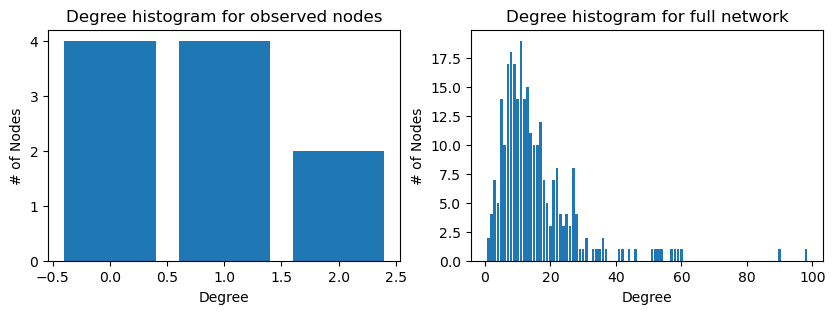

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

degree_sequence = sorted((d for n, d in G_obs.degree()), reverse=True)
ax[0].bar(*np.unique(degree_sequence, return_counts=True))
ax[0].set_title("Degree histogram for observed nodes")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("# of Nodes")
#plt.show()
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
ax[1].bar(*np.unique(degree_sequence, return_counts=True))
ax[1].set_title("Degree histogram for full network")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("# of Nodes")
plt.show()

In [6]:
#plt.scatter(np.arange(n_neurons), position_dict.values(), marker='.')
#plt.hlines(y=[lower_pos_thr, upper_pos_thr], xmin=0, xmax=n_neurons, linestyles='dashed', colors='black')

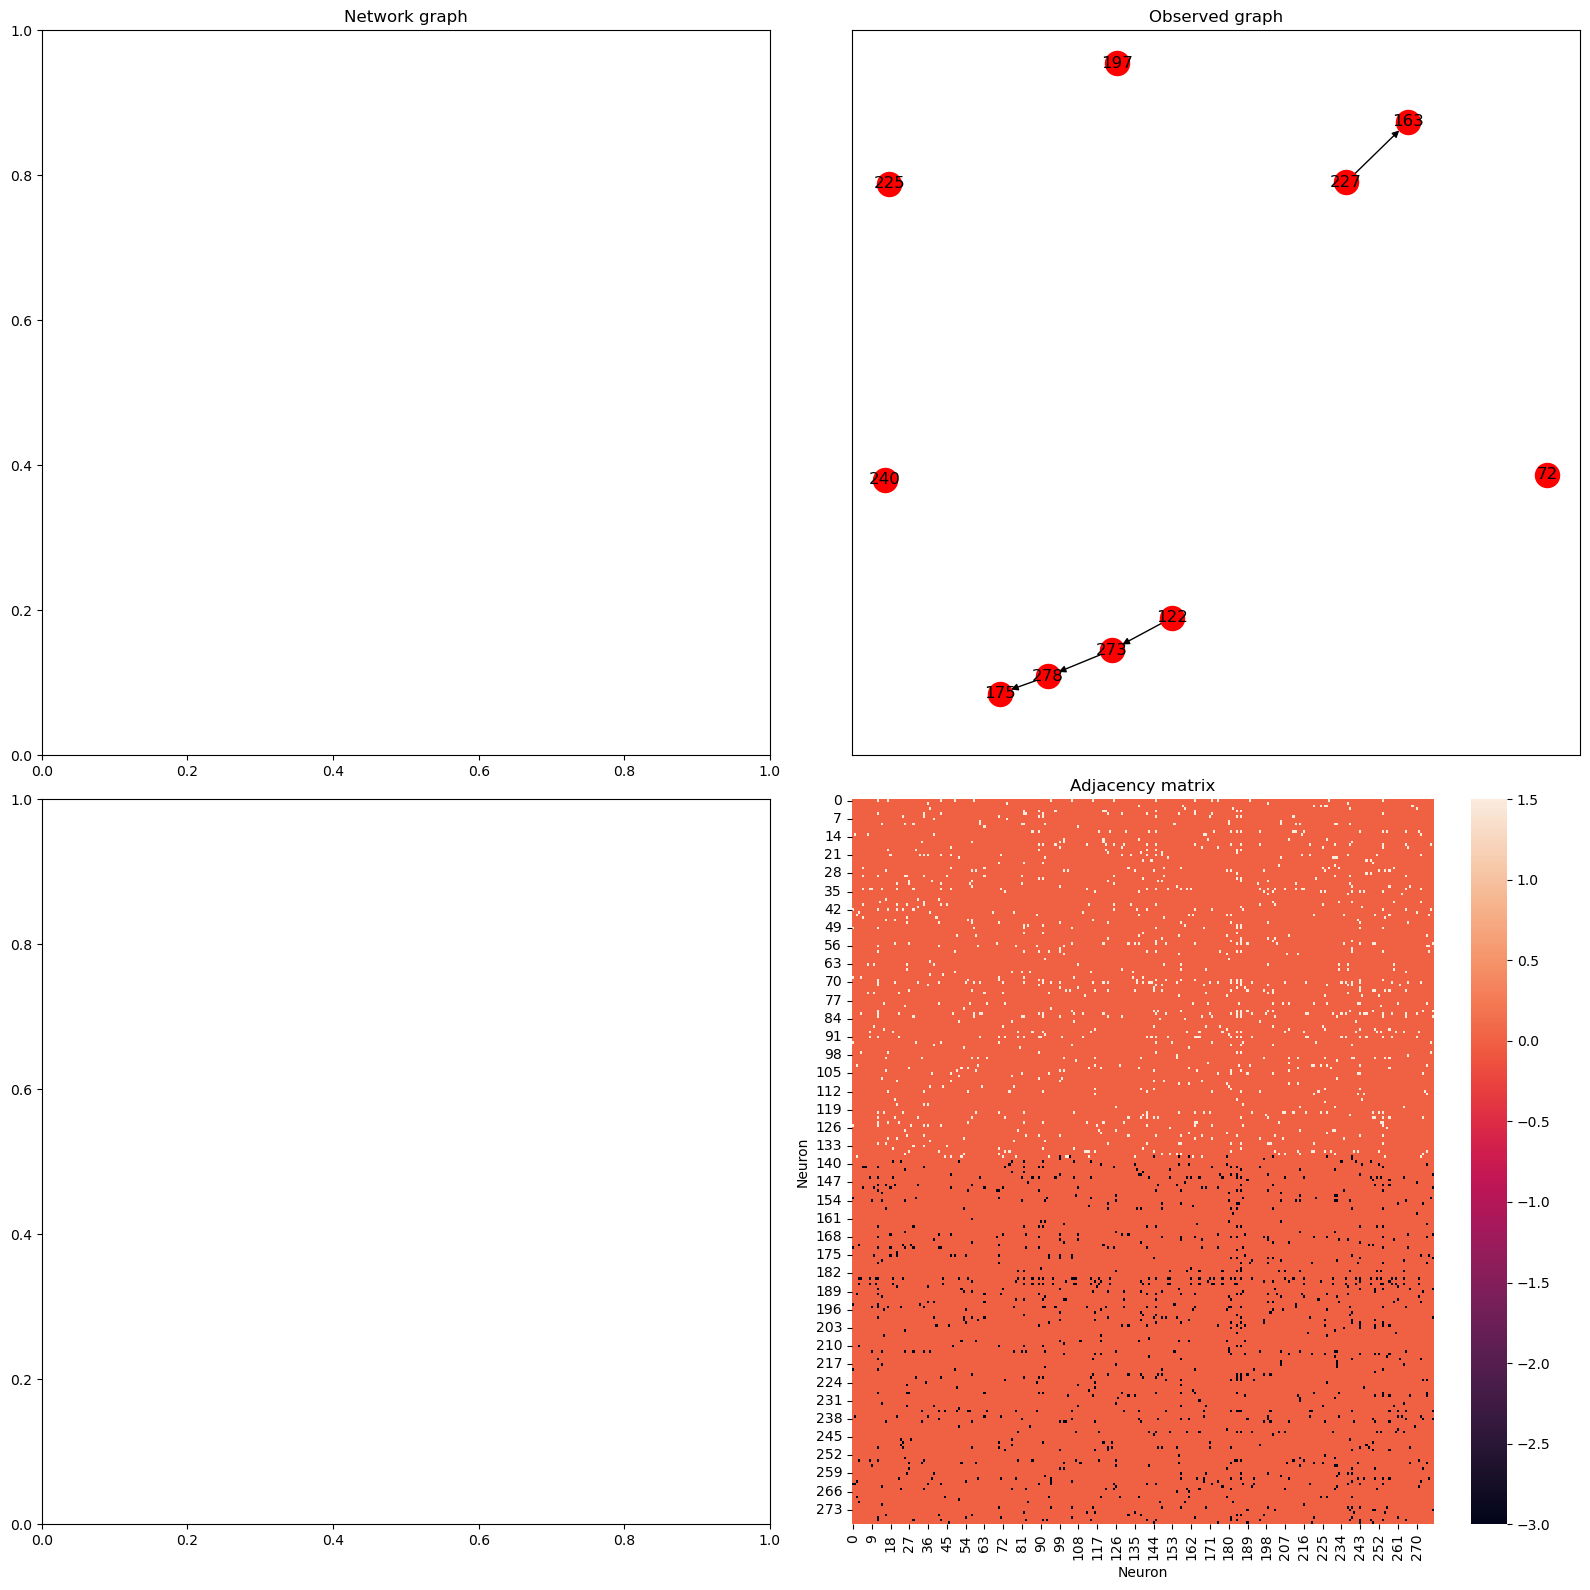

In [7]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
color_map = ['grey' if node not in index_obs else 'red' for node in G]        

#nx.draw_networkx(G, arrows=True, ax=ax[0,0], node_color=color_map)
ax[0,0].set_title("Network graph")

nx.draw_networkx(G_obs, arrows=True, ax=ax[0,1], node_color='red')
ax[0,1].set_title("Observed graph")

W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1,1], annot=False)
ax[1,1].set_title("Adjacency matrix")
ax[1,1].set_xlabel("Neuron")
ax[1,1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

In [8]:
prop_intervened = 1.0

spike_data = []
spike_data_dict = dict()
n_timesteps = 10**4

# complete single neuron stimulation protocol
stimulation_protocol = [[i] for i in index_obs]
stimulation_protocol_str = [str(i) for i in index_obs] + ['null']

stimulate_nodes = np.sort(np.random.choice(index_obs, size = int(len(index_obs)*prop_intervened), replace = False))
stimulation_protocol = [[i] for i in stimulate_nodes]
stimulation_protocol_str = [str(i) for i in stimulate_nodes] + ['null']

In [9]:
for i, intervention in tqdm(enumerate(stimulation_protocol_str), total = len(stimulation_protocol_str)):
    stimulus_mask = torch.zeros(n_neurons, dtype=torch.bool)
    
    if intervention != 'null':
        intervention_set = stimulation_protocol[i]
        stimulus_mask[intervention_set] = True
        
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)
    
    spike_data_dict[intervention] = spikes[index_obs]

100%|███████████████████████████████████████████| 11/11 [00:08<00:00,  1.35it/s]


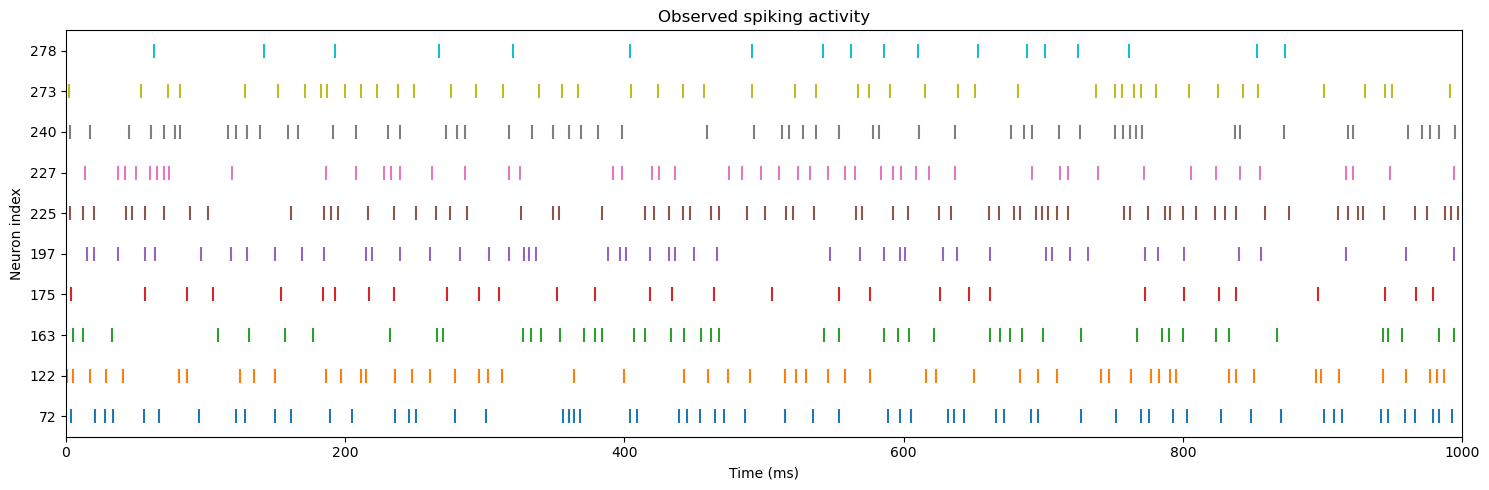

In [10]:
spikes = spike_data_dict['null']

plt.figure(figsize=(15,5))

for i in range(len(index_obs)):
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)

plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0, 1000])
plt.ylim([-0.5, n_obs - 0.5])
plt.title("Observed spiking activity")
plt.tight_layout()
plt.show()

In [11]:
len(index_obs)

10

In [12]:
G_learned = observational_learner_Poisson(spike_data_dict, 
                        node_list=list(index_obs), 
                        alpha = 0.01)

100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.43s/it]


In [13]:
G_true = nx.subgraph(G, index_obs)

print('SHD = ', compute_SHD(G_learned=G_learned, G_true=G_true))
print('Sensitivity = ', compute_sensitivity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))
print('specificity = ', compute_specificity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))

SHD =  1
Sensitivity =  0.8
specificity =  1.0


In [14]:
interventional_learner_Poisson(spike_data_dict, 
                               node_list=index_obs, 
                               stimulation_protocol=stimulation_protocol,
                               SCM_learned=G_learned,
                               alpha=0.01)

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/vildeung/anaconda3/envs/spikeenv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/vildeung/anaconda3/envs/spikeenv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/vildeung/anaconda3/envs/spikeenv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1243: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
 10%|████▍                                       | 1/10 [00:00<00:03,  2.48it/s]


ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

- plot antall FP eller FN på y-aksen som funksjon av antall celler observert
- ROC kurve 
- se på hvor mye reel konfounding det er i dataene du jobber med (hvis alle nevroner i hodet er observert forsvinner confounding effekter raskt)
    - kan man kvantifisere hvor mye confounding det er i systemet?
    - Fx ved å telle antall ikke-observerte noder som er foreldre til to eller flere av de observerte nodene


### For numerical experiments
- Should perhaps save the spike data of I produce for c_elegans, to save time
- I want to explore the relationship between num. confounding variables, prop. observed variables, sensitivity and specificity
- want to automate the numerical experiment more than how i do now

In [177]:
with open('data/c_elegans_spike_data_single_node_stimuli.pickle', 'rb') as f:
    data = pickle.load(f)

In [178]:
data['0'].shape

torch.Size([279, 10000])

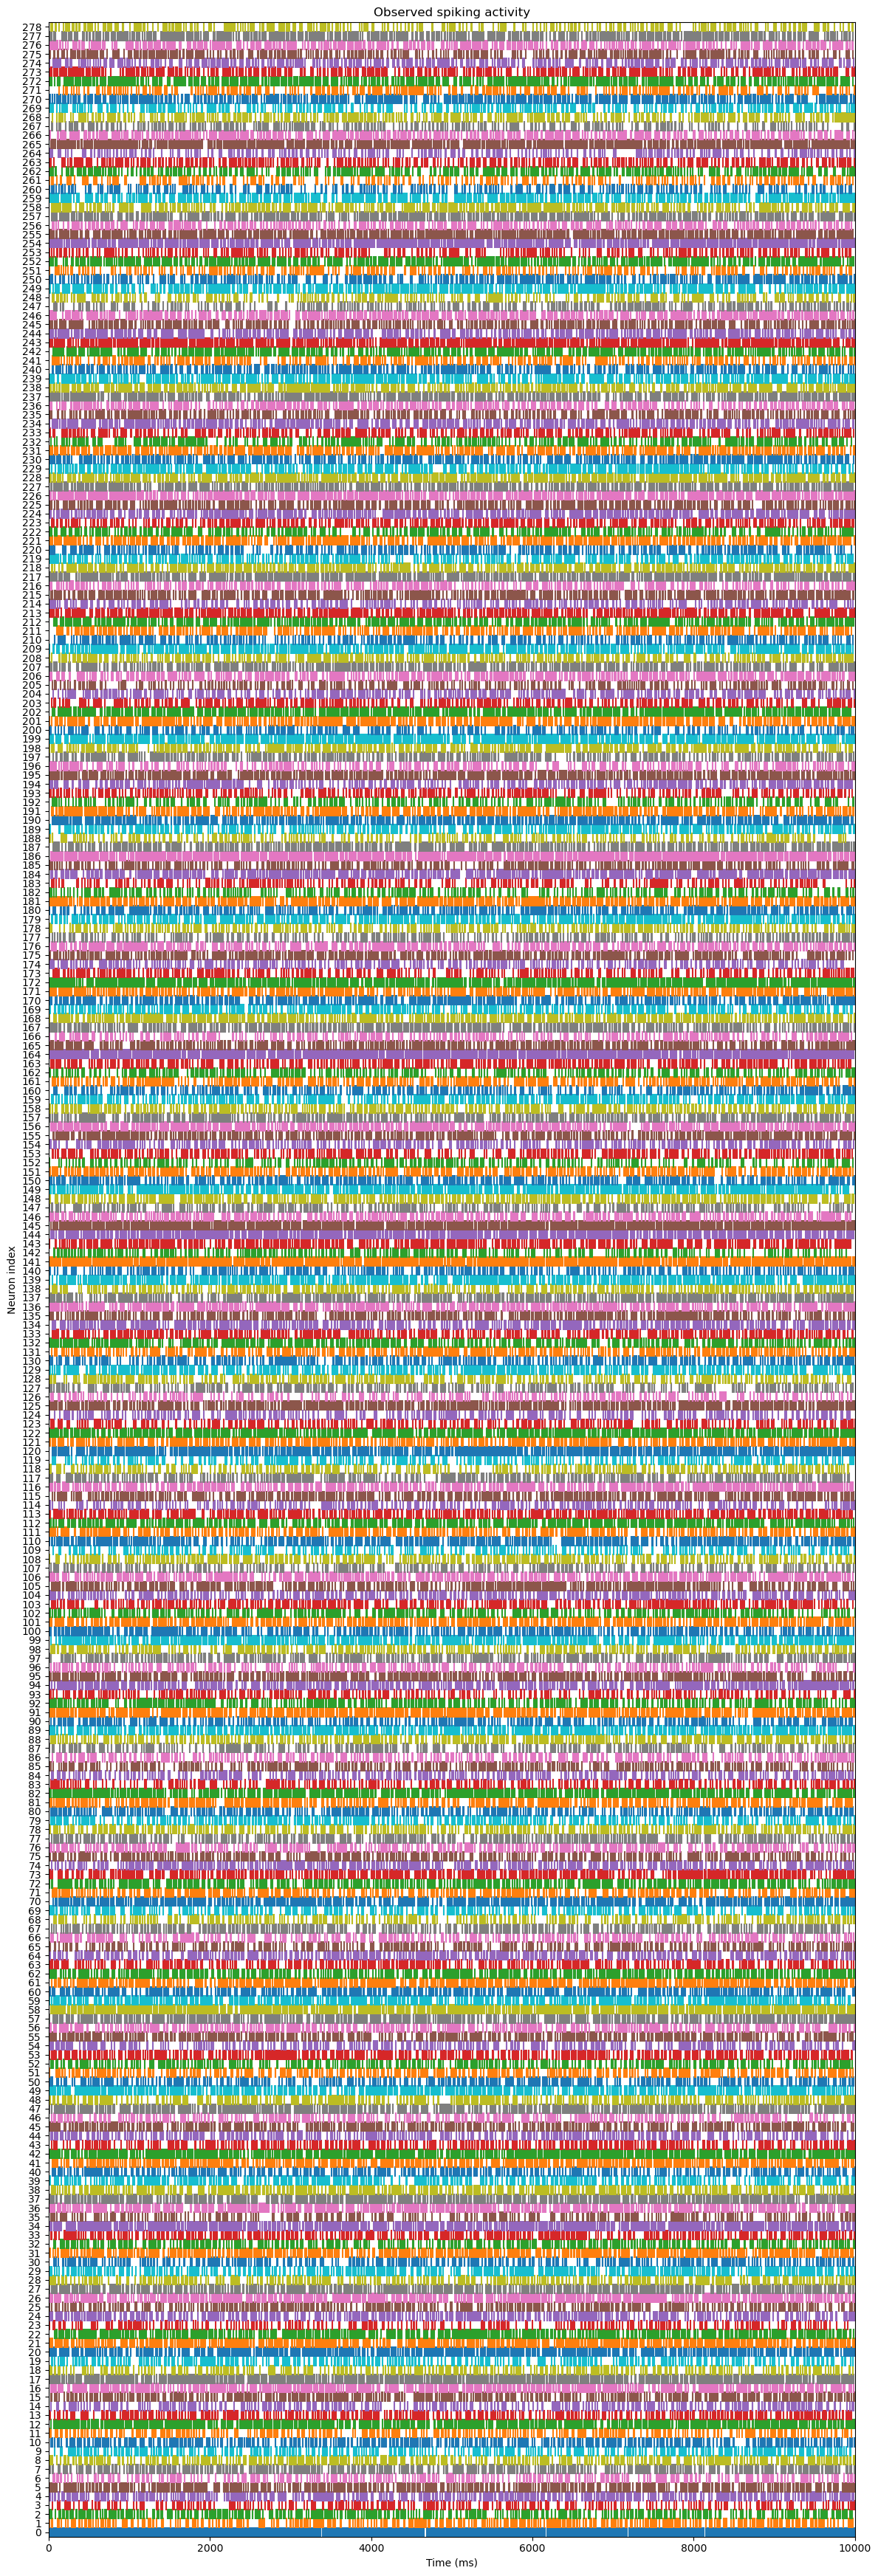

In [180]:
spikes = data['0']

plt.figure(figsize=(12,35))

for i in range(spikes.shape[0]):
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)

plt.yticks(ticks=np.arange(spikes.shape[0]))
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0, 10000])
plt.ylim([-0.5, spikes.shape[0] - 0.5])
plt.title("Observed spiking activity")
plt.tight_layout()
plt.show()

In [149]:
with open(f'data/c_elegans_spike_data_single_node_stimuli.pickle','rb') as f:
        spike_data = pickle.load(f, encoding='latin1')  

EOFError: Ran out of input